# その他のパッケージ

機械学習の分野では以下の 5 つのパッケージが良く用いられます。

* **NumPy** : 数値計算に特化したパッケージ。scikit-learn や Chainer を含めた多くの機械学習のライブラリや深層学習フレームワークで用いられています。計算は CPU (Central Processing Unit) 上で実行されます。
* **scikit-learn**： 機械学習に特化したパッケージ。様々な手法の実装や、前処理を行うことができます。
* **CuPy** : NumPy と同様のインターフェースを持つ数値計算ライブラリ。NumPy で提供されている多くの機能を NVIDIA GPU (Graphics Processing Unit) 向けに提供しています。NumPy で書かれたコードを GPU を活用して高速化することができます。
* **Pandas** : データ操作に特化したパッケージです。表の結合や条件抽出だけでなく、統計量の算出や描画などサポートしています。
* **Matplotlib** : データの可視化に特化したパッケージです。棒グラフ、散布図、ヒストグラムなどを扱え、統計的なグラフは seaborn を使うと、さらに簡単かつ綺麗に表示できます。

NumPy、scikit-learnはそれぞれ 5 章、6 章で紹介しました。この章では残りの CuPy 、Pandas、Matplotlib の紹介をします。

## CuPy 

CuPy は GPU での演算に特化した数値計算用のパッケージです。  
膨大な量かつ単純な数値計算を行う際に、GPU の計算能力を活用して CPU を用いる NumPy よりも高速に計算を行うことができます。



### GPU とは

**GPU**  (Graphics Processing Unit) は 3D グラフィックの描画や、画像処理を高速に計算できるように設計された演算装置です。
一方、一般的な計算で使用される CPU (Central Processing Unit) は幅広い多くの処理で利用されることを想定して設計されています。CPUとGPUを比較すると、GPUは一部の計算に特化しており、条件分岐を多用する複雑な計算には向かないとされている一方、行列計算のような処理では CPU よりも高い性能を発揮することが知られています。

深層学習では、行列計算を多く行うため、GPU との相性が良く、GPU による演算の高速化が期待できます。

![GPU](https://www.nvidia.com/content/dam/en-zz/es_em/es_em/Solutions/Data-Center/tesla-v100/data-center-tesla-v100-pcie-625-ud@2x.jpg)
出典：[NVIDIA](https://www.nvidia.com/ja-jp/data-center/tesla-v100/)

以下の動画では直感的に CPU と GPU の違いを理解できるため、ぜひご覧ください。

In [1]:
from IPython.display import IFrame
IFrame('https://www.youtube.com/embed/-P28LKWTzrI', 560, 315)

### Colab で GPU を使用するための事前準備

1 章で紹介した通り、Colab ではGPU を使用することができます。以降でGPU を使いますので、Colab のメニュー項目の「ランタイム」から「ランタイムのタイプを変更」を選択し、「ハードウェアアクセラレータ」と書かれたプルダウンメニューからから GPU を指定してください。


### 重回帰分析を利用した CuPy の使用例

重回帰分析のアルゴリズムを例に NumPy と比較しながら、 CuPy の使用方法を紹介します。

CuPy の基本的な使用方法は NumPy と同じです。  
そのため NumPy の使用方法を知っていれば、`numpy` の部分を `cupy` に置き換えることによって、多くの関数が使用可能です。
また、CuPy は Google Colaboratory 上にインストール済みのため、すぐに使用することができます。

Google Colaboratory 以外を使用する場合には、[CuPy の公式サイト](https://cupy.chainer.org/)を参考にインストールを進めましょう。
CuPy インストール時の注意点として、CuPy では GPU が必要となるため、GPU が搭載されていることなどハードウェア側の要件を満たしている必要があります。

最初に NumPy と CuPy の両モジュールを読み込みます。
`numpy` モジュールを読み込む際に `np` という別名をつけて読み込むことが多いように、`cupy` はしばしば `cp` という別名をつけて読み込まれることが多いようです。

In [0]:
import numpy as np
import cupy as cp

前回までは準備済みのデータセットを使用して、モデルの訓練を行っていましたが、今回はデータ数のスケールを変化させていった際に NumPy と CuPy でどのくらいパフォーマンスに違いが出るのかを調べるために、乱数を用いて作成した人工データを使用します。
適当な乱数を値に持つ行列 `x` の形が、`(10, 10)`, `(100, 100)`, `(1000, 1000)`, `(5000, 5000)` と大きくなっていくにつれ、処理時間がどのように変化するかを確認していきます。

#### NumPy を使用した場合の処理時間測定

最初に NumPy の例を示します。

重回帰分析では以下の正規方程式を解いて重みベクトルを決定しました。

$$
{\bf w} = ({\bf X}^{T}{\bf X})^{-1}{\bf X}{\bf t}
$$

この一連の計算を `get_w_np()` という関数にまとめます。

In [0]:
def get_w_np(x, t):
    xx = np.dot(x.T, x)
    xx_inv = np.linalg.inv(xx)
    xt = np.dot(x.T, t)
    w = np.dot(xx_inv, xt)
    return w

次に、小さい行列を使って`get_w_np()` の動作を確認してみます。

In [4]:
# 一番小さいサイズの行列の準備
N = 10

x = np.random.rand(N, N)
t = np.random.rand(N, 1)
w = get_w_np(x, t)

# 求めた w の先頭 5 件を表示
print(w[:5])

[[-0.44508903]
 [ 0.2414273 ]
 [ 0.61935742]
 [-0.39847548]
 [-0.29119583]]


動作確認ができたので、 小さい行列を使用した場合の `get_w_np()` の経過時間を計測します。
経過時間の測定には `time` モジュールを使用します。

In [0]:
import time

`time.time()` を実行時間を計測したい処理の前後で呼び、その返り値の差を取ることで、おおまかな実行時間を測ることができます。

In [6]:
time_start = time.time()

# - - - 処理 - - -
w = get_w_np(x, t)
# - - - - - - - - - 

time_end = time.time()

elapsed_time = time_end - time_start  # 経過時間

print('{:.5f} sec'.format(elapsed_time))

0.00044 sec


次は、行列の形を大きくして処理時間を測定し、比較を行ってみましょう。

In [7]:
times_cpu = []  # CPUの計算時間保存用

for N in [10, 100, 1000, 5000]:
    np.random.seed(0)
    x = np.random.rand(N, N)
    t = np.random.rand(N, 1)

    time_start = time.time()

    # - - - 処理 - - -
    w = get_w_np(x, t)
    # - - - - - - - - - 

    time_end = time.time()

    elapsed_time = time_end - time_start  # 経過時間

    print('N={:>4}:{:>8.5f} sec'.format(N, elapsed_time))
    
    times_cpu.append(elapsed_time)

N=  10: 0.00094 sec
N= 100: 0.00264 sec
N=1000: 0.20210 sec
N=5000:18.31454 sec


行列の形が大きくなるにつれて、処理にかかる時間が増えていることがわかります。

#### CuPy を使用した場合の処理時間測定

次に CuPy を使用して同様の実験を行ってみます。

最初に説明した通り、CuPy は NumPy と非常に互換性の高いインターフェースを持つように設計されています。
そのため、ソースコード中の `np` を `cp` に置換するだけで計算を GPU 上で行うようコードに変更することができる場合もあります。

それでは、CuPy を使って、重みベクトルを計算する一連の処理をまとめた `get_w_cp()` という関数を定義してみます。

In [0]:
def get_w_cp(x, t):
    xx = cp.dot(x.T, x)
    xx_inv = cp.linalg.inv(xx)
    xt = cp.dot(x.T, t)
    w = cp.dot(xx_inv, xt)
    return w

`get_w_np()` と `get_w_cp()` を比較すると、`get_w_cp()` 内で `np` となっていた部分を `cp` と置き換えた以外、何も変更は行われていないことが分かります。

まず、この CuPy を用いて計算を行う `get_w_cp()` の計算結果が、NumPy を用いる場合と変わらないかどうか確認してみます。

NumPy で実装していた `get_w_np()` の入力のデータ型は `numpy.ndarray` でしたが、CuPy で実装した `get_w_cp()` は `cupy.ndarray` になります。

CuPy の `cupy,random.rand()` を用いて乱数を生成することもできますが、今回は結果が変わらないかを確認するため、`numpy.random.rand()` で乱数を生成し、  そこから`cupy.ndarray` を作るということをします。
これは `cupy.asarray()` を用いて行えます。

In [0]:
# NumPyの乱数生成
N = 10
x_np = np.random.rand(N, N)
t_np = np.random.rand(N, 1)

In [0]:
# NumPy から CuPy へと変換
x_cp = cp.asarray(x_np)
t_cp = cp.asarray(t_np)

入力の準備ができたので、`get_w_np()` と `get_w_cp()` を実行します。

In [11]:
# NumPyの場合
w_np = get_w_np(x_np, t_np)

# 求めた w の先頭 5 件を表示
print(w_np[:5])

[[ 0.32466784]
 [-0.0043603 ]
 [ 0.808385  ]
 [-0.88867075]
 [-0.38284533]]


In [12]:
# CuPyの場合
w_cp = get_w_cp(x_cp, t_cp)

# 求めた w の先頭 5 件を表示
print(w_cp[:5])

[[ 0.32466784]
 [-0.0043603 ]
 [ 0.808385  ]
 [-0.88867075]
 [-0.38284533]]


NumPy と CuPy で同じ結果が得られることが確認できました。

それでは、CuPyでも行列の形を変えて処理の経過時間の変化を計測します。
ここでは NumPy と同じ結果が得られる必要はないので、CuPy で乱数を生成します。

ここで注意点として、CuPyの正しい計算時間を測定する際は、`time.time()` の前に `cp.cuda.Stream.null.synchronize()` を実行する必要があります。
GPUの処理は基本的に CPU と非同期で処理されますが、`cp.cuda.Stream.null.synchronize()` によって、GPUの処理が終わるまで待つことができます。
これにより、GPUの処理が終わる前に `time.time()` が実行されるのを防ぐことができます。

In [13]:
times_gpu = []  # GPUの計算時間保存用

for N in [10, 100, 1000, 5000]:
    cp.random.seed(0)
    x = cp.random.rand(N, N)
    t = cp.random.rand(N, 1)
    cp.cuda.Stream.null.synchronize()

    time_start = time.time()
    
    # - - - 処理 - - -
    w = get_w_cp(x, t)
    # - - - - - - - - - 
    
    cp.cuda.Stream.null.synchronize()
    
    time_end = time.time()
    
    elapsed_time = time_end - time_start  # 経過時間
    
    print('N={:>4}:{:>8.5f} sec'.format(N, elapsed_time))
    
    times_gpu.append(elapsed_time)

N=  10: 0.00083 sec
N= 100: 0.00334 sec
N=1000: 0.04567 sec
N=5000: 0.88040 sec


それではNumPyからCuPyになったことでどれくらい高速になったかを確認します。

In [14]:
# CPU から　GPU に変更して何倍速くなっているか確認
np.array(times_cpu) / np.array(times_gpu)

array([ 1.14174589,  0.78934227,  4.42548515, 20.8025295 ])

この結果からわかる通り、行列の形が小さい（例えば $N=10$ のような場合）には、NumPy と CuPy の計算にほとんど違いがないか、もしくは NumPy の方が速い場合もあります。
一方、`x` の行列の形が大きくなるほど、CuPy を使用した計算のほうが大幅に有利であることがわかります。

Chainer で CPU を使用する場合には、バックエンドのライブラリとして、基本的に NumPy が使用され、 GPU の使用を宣言した場合においては CuPy が使用されます。


## Pandas

Pandas はデータ操作に特化したパッケージであり、データの読み込みや条件抽出など、機械学習アルゴリズムで使用する前のデータ整形の場面で重宝します。

今回は Pandas の操作でよく用いる以下の代表的な操作を行いましょう。

- CSV ファイルの読み書き
- 統計量の算出
- 並び替え
- データの抽出
- 条件を指定した抽出
- 条件を指定した置換
- 欠損値の除去 / 補間
- NumPy と pandas を相互に変換
- グラフの描画

それでは、上記の操作を紹介する前に Pandas のパッケージを読み込みます。
Pandas は `pd` と短縮することが一般的です。

In [0]:
import pandas as pd

### CSV ファイルの読み書き

データセットはGoogle Colaboratoryで用意されているサンプルデータを使用します。  

データセットの読み込みは `read_csv()`  という関数が用意されています。
また、読み込んだデータを格納する変数名は data frame の頭文字をとった `df` を使用することが多いため、覚えておきましょう。

In [0]:
# データセットの読み込み
df = pd.read_csv('sample_data/california_housing_train.csv')

In [17]:
# 型の確認
type(df)

pandas.core.frame.DataFrame

次に`df` の中身の確認をします。`df`の中身は `df` と変数名だけで実行すると表示されます。ただし、大きなCSVファイルを読み込んだ場合は一部省略されます。

In [18]:
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -114.31     34.19                15.0       5612.0          1283.0   
1        -114.47     34.40                19.0       7650.0          1901.0   
2        -114.56     33.69                17.0        720.0           174.0   
3        -114.57     33.64                14.0       1501.0           337.0   
4        -114.57     33.57                20.0       1454.0           326.0   
5        -114.58     33.63                29.0       1387.0           236.0   
6        -114.58     33.61                25.0       2907.0           680.0   
7        -114.59     34.83                41.0        812.0           168.0   
8        -114.59     33.61                34.0       4789.0          1175.0   
9        -114.60     34.83                46.0       1497.0           309.0   
10       -114.60     33.62                16.0       3741.0           801.0   
11       -114.60     33.60                21.0       1988.0           483.0   
12       -114.61     34.84                48.0       1291.0           248.0   
13       -114.61     34.83                31.0       2478.0           464.0   
14       -114.63     32.76                15.0       1448.0           378.0   
15       -114.65     34.89                17.0       2556.0           587.0   
16       -114.65     33.60                28.0       1678.0           322.0   
17       -114.65     32.79                21.0         44.0            33.0   
18       -114.66     32.74                17.0       1388.0           386.0   
19       -114.67     33.92                17.0         97.0            24.0   
20       -114.68     33.49                20.0       1491.0           360.0   
21       -114.73     33.43                24.0        796.0           243.0   
22       -114.94     34.55                20.0        350.0            95.0   
23       -114.98     33.82                15.0        644.0           129.0   
24       -115.22     33.54                18.0       1706.0           397.0   
25       -115.32     32.82                34.0        591.0           139.0   
26       -115.37     32.82                30.0       1602.0           322.0   
27       -115.37     32.82                14.0       1276.0           270.0   
28       -115.37     32.81                32.0        741.0           191.0   
29       -115.37     32.81                23.0       1458.0           294.0   
...          ...       ...                 ...          ...             ...   
16970    -124.17     40.80                52.0       1606.0           419.0   
16971    -124.17     40.80                52.0       1557.0           344.0   
16972    -124.17     40.79                43.0       2285.0           479.0   
16973    -124.17     40.78                39.0       1606.0           330.0   
16974    -124.17     40.77                30.0       1895.0           366.0   
16975    -124.17     40.76                26.0       1776.0           361.0   
16976    -124.17     40.75                13.0       2171.0           339.0   
16977    -124.17     40.62                32.0       1595.0           309.0   
16978    -124.18     40.79                39.0       1836.0           352.0   
16979    -124.18     40.78                37.0       1453.0           293.0   
16980    -124.18     40.78                34.0       1592.0           364.0   
16981    -124.18     40.78                33.0       1076.0           222.0   
16982    -124.18     40.62                35.0        952.0           178.0   
16983    -124.19     41.78                15.0       3140.0           714.0   
16984    -124.19     40.78                37.0       1371.0           319.0   
16985    -124.19     40.77                30.0       2975.0           634.0   
16986    -124.19     40.73                21.0       5694.0          1056.0   
16987    -124.21     41.77                17.0       3461.0           722.0   
16988    -124.21     41.75                20.0       3810

`df` と変数名だけで実行すると、表が綺麗に表示されますが、今回のように表が大き過ぎる場合があります。データの構造など確認するだけであれば `head()`を使用します。
`head()` はデフォルトで 5 件表示されますが、`head(3)` のように引数として表示したい件数を指定することができます。`head()` を実行してみます。

In [19]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
3       515.0       226.0         3.1917             73400.0  
4       624.0       262.0         1.9250             65500.0

In [20]:
df.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0

各列にアクセスしたい場合には、辞書のように列の名前をキーとしてしているするとアクセスすることができます。

In [21]:
df['longitude'].head(3)

0   -114.31
1   -114.47
2   -114.56
Name: longitude, dtype: float64

Pandas ではCSVファイルの読み込みだけでなく、書き込みを簡単に行う `to_csv()` が用意されています。

In [0]:
df.to_csv('sample.csv')

In [23]:
%%bash
ls

sample.csv
sample_data


### 統計量の算出

`pandas.DataFrame` は `numpy.ndarray`と同じような機能を持っており、統計量やデータ構造に関する情報が簡単に取得できます。

In [24]:
# 形の確認
df.shape

(17000, 9)

In [25]:
# 平均
df.mean()

longitude               -119.562108
latitude                  35.625225
housing_median_age        28.589353
total_rooms             2643.664412
total_bedrooms           539.410824
population              1429.573941
households               501.221941
median_income              3.883578
median_house_value    207300.912353
dtype: float64

In [26]:
# レコードの数（欠損値を見つけるために使えます）
df.count()

longitude             17000
latitude              17000
housing_median_age    17000
total_rooms           17000
total_bedrooms        17000
population            17000
households            17000
median_income         17000
median_house_value    17000
dtype: int64

また、データの特徴をおおまかに理解するためにとても便利な機能として、概要を算出できる `describe()` 関数も用意されています。

In [27]:
# データの概要
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  17000.000000  17000.000000        17000.000000  17000.000000   
mean    -119.562108     35.625225           28.589353   2643.664412   
std        2.005166      2.137340           12.586937   2179.947071   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.790000     33.930000           18.000000   1462.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.000000     37.720000           37.000000   3151.250000   
max     -114.310000     41.950000           52.000000  37937.000000   

       total_bedrooms    population    households  median_income  \
count    17000.000000  17000.000000  17000.000000   17000.000000   
mean       539.410824   1429.573941    501.221941       3.883578   
std        421.499452   1147.852959    384.520841       1.908157   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    790.000000    282.000000       2.566375   
50%        434.000000   1167.000000    409.000000       3.544600   
75%        648.250000   1721.000000    605.250000       4.767000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        17000.000000  
mean        207300.912353  
std         115983.764387  
min          14999.000000  
25%         119400.000000  
50%         180400.000000  
75%         265000.000000  
max         500001.000000

また、もうひとつ便利な関数として相関係数を算出する `corr` があります。
入力変数間や入出力間の相関を事前に手軽に確認することができます。

In [28]:
# 相関係数の算出
df.corr()

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.925208           -0.114250     0.047010   
latitude            -0.925208  1.000000            0.016454    -0.038773   
housing_median_age  -0.114250  0.016454            1.000000    -0.360984   
total_rooms          0.047010 -0.038773           -0.360984     1.000000   
total_bedrooms       0.071802 -0.069373           -0.320434     0.928403   
population           0.101674 -0.111261           -0.295890     0.860170   
households           0.059628 -0.074902           -0.302754     0.919018   
median_income       -0.015485 -0.080303           -0.115932     0.195383   
median_house_value  -0.044982 -0.144917            0.106758     0.130991   

                    total_bedrooms  population  households  median_income  \
longitude                 0.071802    0.101674    0.059628      -0.015485   
latitude                 -0.069373   -0.111261   -0.074902      -0.080303   
housing_median_age       -0.320434   -0.295890   -0.302754      -0.115932   
total_rooms               0.928403    0.860170    0.919018       0.195383   
total_bedrooms            1.000000    0.881169    0.980920      -0.013495   
population                0.881169    1.000000    0.909247      -0.000638   
households                0.980920    0.909247    1.000000       0.007644   
median_income            -0.013495   -0.000638    0.007644       1.000000   
median_house_value        0.045783   -0.027850    0.061031       0.691871   

                    median_house_value  
longitude                    -0.044982  
latitude                     -0.144917  
housing_median_age            0.106758  
total_rooms                   0.130991  
total_bedrooms                0.045783  
population                   -0.027850  
households                    0.061031  
median_income                 0.691871  
median_house_value            1.000000

### 並び替え

昇順 (ascending) や降順 (descending) にある列を対象として `sort_values()` を用いて並び替えを行えます。
なお、関数を実行した際に、`df` のデータに対して並べ替えした結果が上書きされるわけではないため、別の変数を用意します。

In [0]:
# total_rooms の列を基準に昇順に並び替え
df_as = df.sort_values(by='total_rooms')

In [30]:
df_as.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2990     -117.79     35.21                 4.0          2.0             2.0   
16309    -122.50     37.79                52.0          8.0             1.0   
8188     -118.44     34.28                46.0         11.0            11.0   
15369    -122.29     37.81                46.0         12.0             4.0   
15656    -122.37     37.60                26.0         15.0             3.0   

       population  households  median_income  median_house_value  
2990          6.0         2.0         2.3750            137500.0  
16309        13.0         1.0        15.0001            500001.0  
8188         24.0        13.0         2.8750            162500.0  
15369        18.0         7.0         0.4999             67500.0  
15656        11.0         3.0         5.0480            350000.0

この結果から分かる通り、デフォルトの設定では、小さいものから順番に並べられた昇順となっています。
降順に並べ替える場合は、関数の引数を確認（Google Colablatoryの場合は tab を 2 回押す）するとわかりますが、`ascending=True` とデフォルトの設定となっているところを `ascending=False` のように変更します。

In [0]:
# total_roomsの列を基準に降順に並び替え
df_de = df.sort_values(by='total_rooms', ascending=False)

In [32]:
df_de.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2871     -117.74     33.89                 4.0      37937.0          5471.0   
12772    -121.79     36.64                11.0      32627.0          6445.0   
2969     -117.78     34.03                 8.0      32054.0          5290.0   
8881     -118.78     34.16                 9.0      30405.0          4093.0   
1116     -117.12     33.52                 4.0      30401.0          4957.0   

       population  households  median_income  median_house_value  
2871      16122.0      5189.0         7.4947            366300.0  
12772     28566.0      6082.0         2.3087            118800.0  
2969      15507.0      5050.0         6.0191            253900.0  
8881      12873.0      3931.0         8.0137            399200.0  
1116      13251.0      4339.0         4.5841            212300.0

### データの抽出

必要な要素や行、列を抽出することも簡単にできます。
前章の scikit-learn の使い方で学んだ通り、入力変数 `x` と目標値 `t` を用意する必要があります。このようなとき、入力変数に対応する列と目標値に対応する列だけをそれぞれ抽出するということができます。

今回は右端の列である `median_house_value` が目標値でそれ以外が入力変数だとした場合に、それぞれのデータの抽出を行います。
列や行の選択を行う方法にはいくつかありますが、その中でもよく使われる `iloc` を今回は紹介します。

In [33]:
# データの確認
df.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0

In [34]:
# df.iloc[行, 列]
# 0番目のlongitude
df.iloc[0, 0]

-114.31

In [35]:
# 1番目のlatitude
df.iloc[1, 1]

34.4

`iloc` はリストのスライス機能と同じであり、複数行や複数列は `:` をうまく使いましょう。
また、`-1` は最後の要素を意味するため、これもうまく使いましょう。

In [0]:
# すべて (:) の行で、最後 (-1) の列
t = df.iloc[:, -1]

In [37]:
# 先頭3件の表示
t.head(3)

0    66900.0
1    80100.0
2    85700.0
Name: median_house_value, dtype: float64

In [38]:
# 型の確認
type(t)

pandas.core.series.Series

1列だけ抽出した際には、`pandas.Series` になります。
`pandas.DataFrame` のようにテーブルが綺麗に表示されなくなりますが、平均の算出などは同様に行うことができます。

In [0]:
# すべて (:) の行で、最初 (0) から最後 (-1) の列のひとつ手前まで
x = df.iloc[:, 0:-1]

最初の 0 は省略できるため、一般的に以下のように書きます。

In [0]:
# すべて (:) の行で、最初 (省略) から最後 (-1) の列のひとつ手前まで
x = df.iloc[:, :-1]

In [41]:
# 先頭の3件の表示
x.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   

   population  households  median_income  
0      1015.0       472.0         1.4936  
1      1129.0       463.0         1.8200  
2       333.0       117.0         1.6509

In [42]:
# 型の確認
type(x)

pandas.core.frame.DataFrame

### 条件を指定したデータの抽出

次に条件を指定したデータの抽出を紹介します。

対象とする列の名前を `col` とすると、`df[col] > 300` や `df[col] == 10` のように比較演算子を使って条件を指定し、比較演算子の結果を使って指定したデータを抽出します。

In [0]:
# 対象とする列名が長いため、あらかじめ代入
col = 'median_house_value'

In [44]:
# データの確認
df[col].head()

0    66900.0
1    80100.0
2    85700.0
3    73400.0
4    65500.0
Name: median_house_value, dtype: float64

In [0]:
index = df[col] > 70000

In [46]:
index.head()

0    False
1     True
2     True
3     True
4    False
Name: median_house_value, dtype: bool

この結果からわかる通り、比較演算子を実行したあとに得られる結果は各行に対する True / False です。
この結果が True の行のみを抽出したい場合は `df[index]` のように記述します。

In [47]:
# df[index]
df[index].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
5    -114.58     33.63                29.0       1387.0           236.0   
6    -114.58     33.61                25.0       2907.0           680.0   

   population  households  median_income  median_house_value  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
3       515.0       226.0         3.1917             73400.0  
5       671.0       239.0         3.3438             74000.0  
6      1841.0       633.0         2.6768             82400.0

この処理のように、`index` に True / False を入れて、その True の部分のみを抽出する処理は NumPy や Pandas でよく用いられます。

複数条件の場合は `()` が必要となります。
論理和は `|`、論理積は `&` を用います。

In [48]:
df[col].head()

0    66900.0
1    80100.0
2    85700.0
3    73400.0
4    65500.0
Name: median_house_value, dtype: float64

In [0]:
# 70000よりも小さい（もしくは）80000よりも大きい
index = (df[col] < 70000) | (df[col] > 80000)

In [50]:
index.head()

0     True
1     True
2     True
3    False
4     True
Name: median_house_value, dtype: bool

In [51]:
df[index].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
4    -114.57     33.57                20.0       1454.0           326.0   
6    -114.58     33.61                25.0       2907.0           680.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
4       624.0       262.0         1.9250             65500.0  
6      1841.0       633.0         2.6768             82400.0

In [0]:
# 70000より大きく（かつ）80000より小さい
index = (df[col] > 70000) & (df[col] < 80000)

In [53]:
index.head()

0    False
1    False
2    False
3     True
4    False
Name: median_house_value, dtype: bool

In [54]:
df[index].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3     -114.57     33.64                14.0       1501.0           337.0   
5     -114.58     33.63                29.0       1387.0           236.0   
13    -114.61     34.83                31.0       2478.0           464.0   
23    -114.98     33.82                15.0        644.0           129.0   
26    -115.37     32.82                30.0       1602.0           322.0   

    population  households  median_income  median_house_value  
3        515.0       226.0         3.1917             73400.0  
5        671.0       239.0         3.3438             74000.0  
13      1346.0       479.0         3.2120             70400.0  
23       137.0        52.0         3.2097             71300.0  
26      1130.0       335.0         3.5735             71100.0

少し複雑な記述に見えてしまいますが、条件の定義から抽出まで1行でまとめて書くこともできます。

In [55]:
df[(df[col] > 70000) & (df[col] < 80000)].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3     -114.57     33.64                14.0       1501.0           337.0   
5     -114.58     33.63                29.0       1387.0           236.0   
13    -114.61     34.83                31.0       2478.0           464.0   
23    -114.98     33.82                15.0        644.0           129.0   
26    -115.37     32.82                30.0       1602.0           322.0   

    population  households  median_income  median_house_value  
3        515.0       226.0         3.1917             73400.0  
5        671.0       239.0         3.3438             74000.0  
13      1346.0       479.0         3.2120             70400.0  
23       137.0        52.0         3.2097             71300.0  
26      1130.0       335.0         3.5735             71100.0

### 条件を指定した置換

抽出だけでなく、条件を指定した置換も行うことができます。
例えば、`median_house_value` に対して、以下のような条件のときに数字を割り当てた `target` という列を `df` に追加したいとします。

- 60000より小さい場合は 0
- 60000以上70000未満は 1
- 70000以上80000未満は 2
- 80000以上は 3

これは以下のようにして `df` に追加することができます。

In [0]:
# あらかじめ新しい列 target を None で初期化
df['target'] = None

In [57]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value target  
0      1015.0       472.0         1.4936             66900.0   None  
1      1129.0       463.0         1.8200             80100.0   None  
2       333.0       117.0         1.6509             85700.0   None  
3       515.0       226.0         3.1917             73400.0   None  
4       624.0       262.0         1.9250             65500.0   None

In [0]:
index1 = df[col] < 60000
index2 = (df[col] >= 60000) & (df[col] < 70000)
index3 = (df[col] >= 70000) & (df[col] < 80000)
index4 = df[col] >= 80000

行や列を数値で指定する場合は`iloc` を使用しましたが、列の名前を使用する場合には `loc` を用います。

In [0]:
df.loc[index1, 'target'] = 0
df.loc[index2, 'target'] = 1
df.loc[index3, 'target'] = 2
df.loc[index4, 'target'] = 3

In [60]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  target  
0      1015.0       472.0         1.4936             66900.0       1  
1      1129.0       463.0         1.8200             80100.0       3  
2       333.0       117.0         1.6509             85700.0       3  
3       515.0       226.0         3.1917             73400.0       2  
4       624.0       262.0         1.9250             65500.0       1

この結果のように、条件の指定の置換を駆使することで、目的の列を追加できました。

### 欠損値の除去 / 補間

実データでは値が入っていない欠損値を含んでいることがしばしばあります。
この欠損値への対策としては、欠損値を含む行、または列を除去するか、欠損値を特定の値で補間することが考えられます。

サンプル数が多く、欠損値が多くない場合には、訓練やテストに用いるサンプル数への影響も少ないため、除去してしまうことが一番簡単な対策です。
それに対し、サンプル数が少なかったり、欠損値が多い場合には、訓練やテストに用いるサンプル数への影響を考慮し、補間することが一般的です。

In [0]:
# 欠損値を人為的に作成
df.iloc[0, 0] = None

In [62]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        NaN     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  target  
0      1015.0       472.0         1.4936             66900.0       1  
1      1129.0       463.0         1.8200             80100.0       3  
2       333.0       117.0         1.6509             85700.0       3  
3       515.0       226.0         3.1917             73400.0       2  
4       624.0       262.0         1.9250             65500.0       1

In [63]:
# 欠損値のあるレコードを削除
# df.dropna()
df.dropna().head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   

   population  households  median_income  median_house_value  target  
1      1129.0       463.0         1.8200             80100.0       3  
2       333.0       117.0         1.6509             85700.0       3  
3       515.0       226.0         3.1917             73400.0       2

この結果より、0 番目の行が除去されていることがわかります。

次に、平均を使って補間を行っていきます。

In [64]:
mean = df.mean()
mean

longitude               -119.562417
latitude                  35.625225
housing_median_age        28.589353
total_rooms             2643.664412
total_bedrooms           539.410824
population              1429.573941
households               501.221941
median_income              3.883578
median_house_value    207300.912353
target                     2.808412
dtype: float64

In [65]:
# df.fillna(mean)
df.fillna(mean).head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.562417     34.19                15.0       5612.0          1283.0   
1 -114.470000     34.40                19.0       7650.0          1901.0   
2 -114.560000     33.69                17.0        720.0           174.0   

   population  households  median_income  median_house_value  target  
0      1015.0       472.0         1.4936             66900.0       1  
1      1129.0       463.0         1.8200             80100.0       3  
2       333.0       117.0         1.6509             85700.0       3

0 番目の `latitude` に平均として算出されていた `-119.562417` が補間されていることがわかります。
今回は 1 箇所だけが対象でしたが、`dropna` や `fillna` を使用することで、対象の箇所に対してすべて適用することができます。

### NumPy と Pandas を相互に変換

scikit-learn では `pandas.Series` や `pandas.DataFrame` を扱うことができます。
しかし、Chainer を含めた他のライブラリやフレームワークでは `numpy.ndarray` のみへの対応となっていることがしばしばあります。
`numpy.ndarray` への変換は `values` を使います。

In [66]:
type(df)

pandas.core.frame.DataFrame

In [67]:
type(df.values)

numpy.ndarray

In [68]:
# pandas.DataFrame のように表が綺麗に表示されることはない
df.values

array([[        nan,  3.4190e+01,  1.5000e+01, ...,  1.4936e+00,
         6.6900e+04,  1.0000e+00],
       [-1.1447e+02,  3.4400e+01,  1.9000e+01, ...,  1.8200e+00,
         8.0100e+04,  3.0000e+00],
       [-1.1456e+02,  3.3690e+01,  1.7000e+01, ...,  1.6509e+00,
         8.5700e+04,  3.0000e+00],
       ...,
       [-1.2430e+02,  4.1840e+01,  1.7000e+01, ...,  3.0313e+00,
         1.0360e+05,  3.0000e+00],
       [-1.2430e+02,  4.1800e+01,  1.9000e+01, ...,  1.9797e+00,
         8.5800e+04,  3.0000e+00],
       [-1.2435e+02,  4.0540e+01,  5.2000e+01, ...,  3.0147e+00,
         9.4600e+04,  3.0000e+00]])

In [69]:
type(df['longitude'])

pandas.core.series.Series

In [70]:
type(df['longitude'].values)

numpy.ndarray

逆に、リストや `numpy.ndarray` から `pandas.Series` や `pandas.DataFrame` への変換を行うこともできます。
NumPy と CuPy の章で使用していた計測時間を格納した `times_cpu` と `times_gpu` を使用します。

In [0]:
# リスト -> pandas.DataFrame
df = pd.DataFrame({
    'cpu': times_cpu,
    'gpu': times_gpu
})

In [72]:
df

cpu       gpu
0   0.000945  0.000828
1   0.002638  0.003342
2   0.202096  0.045666
3  18.314536  0.880399

NumPy の `ndarray` の場合も、リストと同様の処理となります。

In [0]:
# numpy.ndarray -> pandas.DataFrame
times_cpu = np.array(times_cpu)
times_gpu = np.array(times_gpu)
df = pd.DataFrame({
    'cpu': times_cpu,
    'gpu': times_gpu
})

In [74]:
df

cpu       gpu
0   0.000945  0.000828
1   0.002638  0.003342
2   0.202096  0.045666
3  18.314536  0.880399

### グラフの描画

Pandas の `DataFrame` では、次の節で紹介する Matplotlib をバックエンドで利用して、簡単な描画を行うことができます。
詳細なグラフの設定が必要な場合は、Matplotlib で設定することをお勧めします。

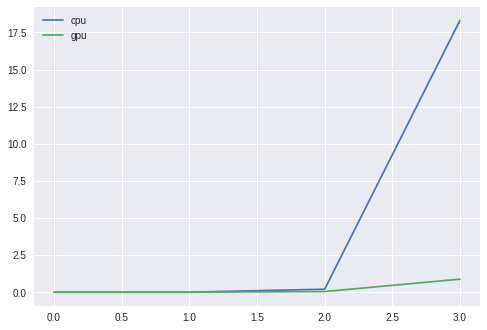

In [75]:
# グラフの描画
df.plot()

## Matplotlib

Pandas の最後でも登場しましたが、グラフの描画を行う場合に Matplotlib が便利です。
Google Colab では標準でプロットを行うと結果が表示されますが、ローカルの Jupyter Notebook の場合、グラフが Notebook 内に描画されない可能性があるため、`%matplotlib inline` を最小に設定しておきます。
Matplotlib は `matplotlib.pyplot` を `plt` として短縮形で読み込むことが一般的です。

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

Pandas の節で CSV を読み込んだ内容から色々と書きかわっているため、再度 CSV ファイルの内容を `df` に読み込みましょう。

In [0]:
df = pd.read_csv('sample_data/california_housing_train.csv')

### 散布図

**散布図 (scatter)** は変数間の相関を確認するために便利なグラフです。Matplotlibでは散布図を作成する `scatter()` が用意されています。

最も強い相関を持っていた `median_income`と`median_house_value` の散布図と、逆に最も弱い相関であった `pupulation` と `median_house_value` の散布図を確認します。

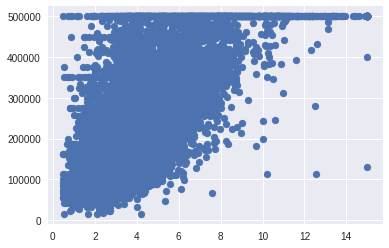

In [78]:
plt.scatter(df['median_income'], df['median_house_value'])

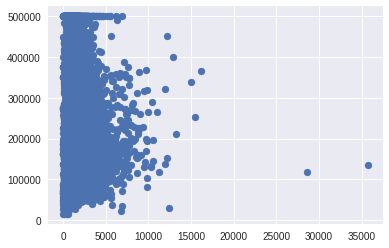

In [79]:
plt.scatter(df['population'], df['median_house_value'])

### ヒストグラム

データの分布を確認するためによく使われるグラフの一つとして、**ヒストグラム (histogram)** があります。
各階級に所属するサンプルの数を計算し、棒グラフで表示しています。
棒グラフ単体は `bar` が用意されていますが、ヒストグラムは `hist` を用います。

(array([ 731., 2958., 3362., 3127., 2291., 1426., 1036.,  629.,  395.,
        1045.]),
 array([ 14999. ,  63499.2, 111999.4, 160499.6, 208999.8, 257500. ,
        306000.2, 354500.4, 403000.6, 451500.8, 500001. ]),
 <a list of 10 Patch objects>)

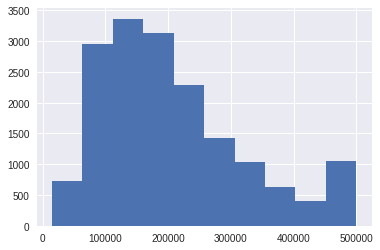

In [80]:
plt.hist(df['median_house_value'])

(array([  8.,  12.,  51., 214., 446., 559., 463., 658., 704., 574., 685.,
        588., 675., 670., 744., 799., 627., 684., 584., 433., 500., 547.,
        484., 406., 358., 370., 362., 267., 257., 166., 184., 197., 199.,
        216., 240., 159., 134., 126.,  98., 112.,  88.,  80.,  69.,  67.,
         91.,  50.,  42.,  44.,  42., 867.]),
 array([ 14999.  ,  24699.04,  34399.08,  44099.12,  53799.16,  63499.2 ,
         73199.24,  82899.28,  92599.32, 102299.36, 111999.4 , 121699.44,
        131399.48, 141099.52, 150799.56, 160499.6 , 170199.64, 179899.68,
        189599.72, 199299.76, 208999.8 , 218699.84, 228399.88, 238099.92,
        247799.96, 257500.  , 267200.04, 276900.08, 286600.12, 296300.16,
        306000.2 , 315700.24, 325400.28, 335100.32, 344800.36, 354500.4 ,
        364200.44, 373900.48, 383600.52, 393300.56, 403000.6 , 412700.64,
        422400.68, 432100.72, 441800.76, 451500.8 , 461200.84, 470900.88,
        480600.92, 490300.96, 500001.  ]),
 <a list of 50 Patch ob

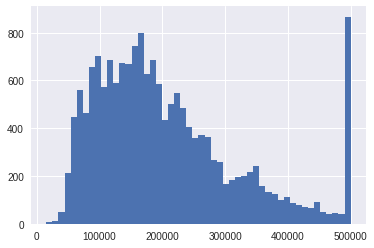

In [81]:
# bins を指定することで、階級の細かさを調整できます
plt.hist(df['median_house_value'], bins=50)

上記のグラフからわかる通り、500,000 周辺に外れたデータの分布が存在していることがわかります。
ヒストグラムを確認することで、どのような分布に従っているか、外れ値は存在するかなどを直感的に把握することができます。

### 箱ひげ図

**箱ひげ図 (box plot)** では、データのばらつきをわかりやすく表現するための統計図であり、データの概要として`pandas.DataFrame.describe()` でも確認していた統計量を可視化することができます。  
下から、最小値、第一四分位点、中央値、第三四分位点、最大値を表しています。

{'boxes': [<matplotlib.lines.Line2D at 0x7f6e1098b5c0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6e1098be48>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6e10917908>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6e10917588>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6e1098b748>,
  <matplotlib.lines.Line2D at 0x7f6e1098bac8>]}

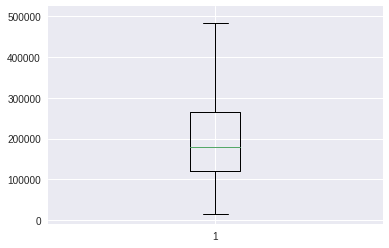

In [82]:
plt.boxplot(df['median_house_value'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f6e108e58d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6e108f0198>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6e108f0c18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6e108f0898>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6e108e5a58>,
  <matplotlib.lines.Line2D at 0x7f6e108f96d8>]}

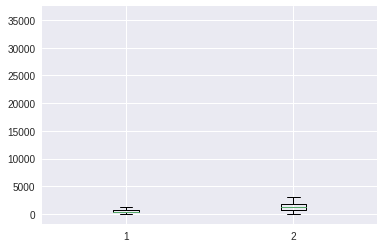

In [83]:
# 複数指定する場合は、タプルを用います
plt.boxplot((df['total_bedrooms'], df['population']))

### 折れ線グラフ

時系列データなどを表示する際に便利なグラフであり、`plot` という関数名で用意されています。

`plot(y)` のように引数が 1 つの場合は、`y` が縦軸の値に対応し、 横軸はサンプルの数となります。

In [0]:
# [0,10]の間を100分割して数値を返す
x = np.linspace(0, 10, 100)

# xの値に乱数を加える
y = x + np.random.randn(100)

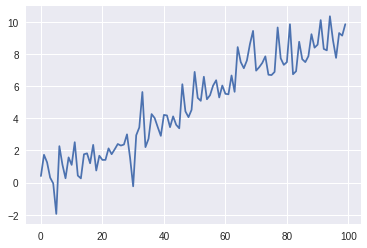

In [85]:
plt.plot(y)

`plot(x, y)` のように引数が 2 つの場合は、`x` が横軸、`y` が縦軸に対応します。

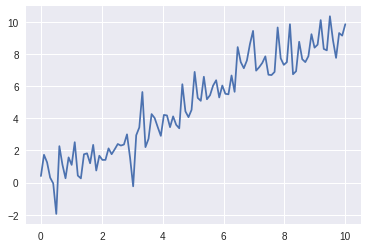

In [86]:
plt.plot(x, y)

### グラフの調整

Matplotlib では横軸や縦軸のラベルの設定や、グラフの大きさの調整、文字の色や大きさの調整など、細かく指定することができます。
この調整に関しては割愛しますが、[公式ページ](https://matplotlib.org/) や技術ブログなどを参考に、調べて使いながら覚えていくことをおすすめします。

### seaborn

Matplotlib を統計系の描画に特化させて、さらに使いやすくしたパッケージとして seaborn が有名です。

In [0]:
import seaborn as sns

データの分布を確認するときに、Matplotlib のヒストグラムよりもわかりやすい `distplot` がおすすめです。

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


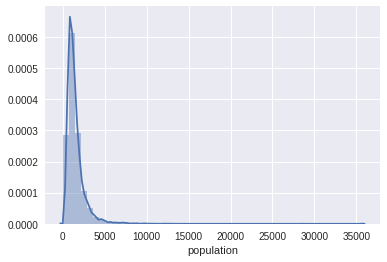

In [88]:
sns.distplot(df['population'])

また、描画まで少し時間がかかりますが、相関関係をすべて描画することができる `pairplot` もおすすめです。

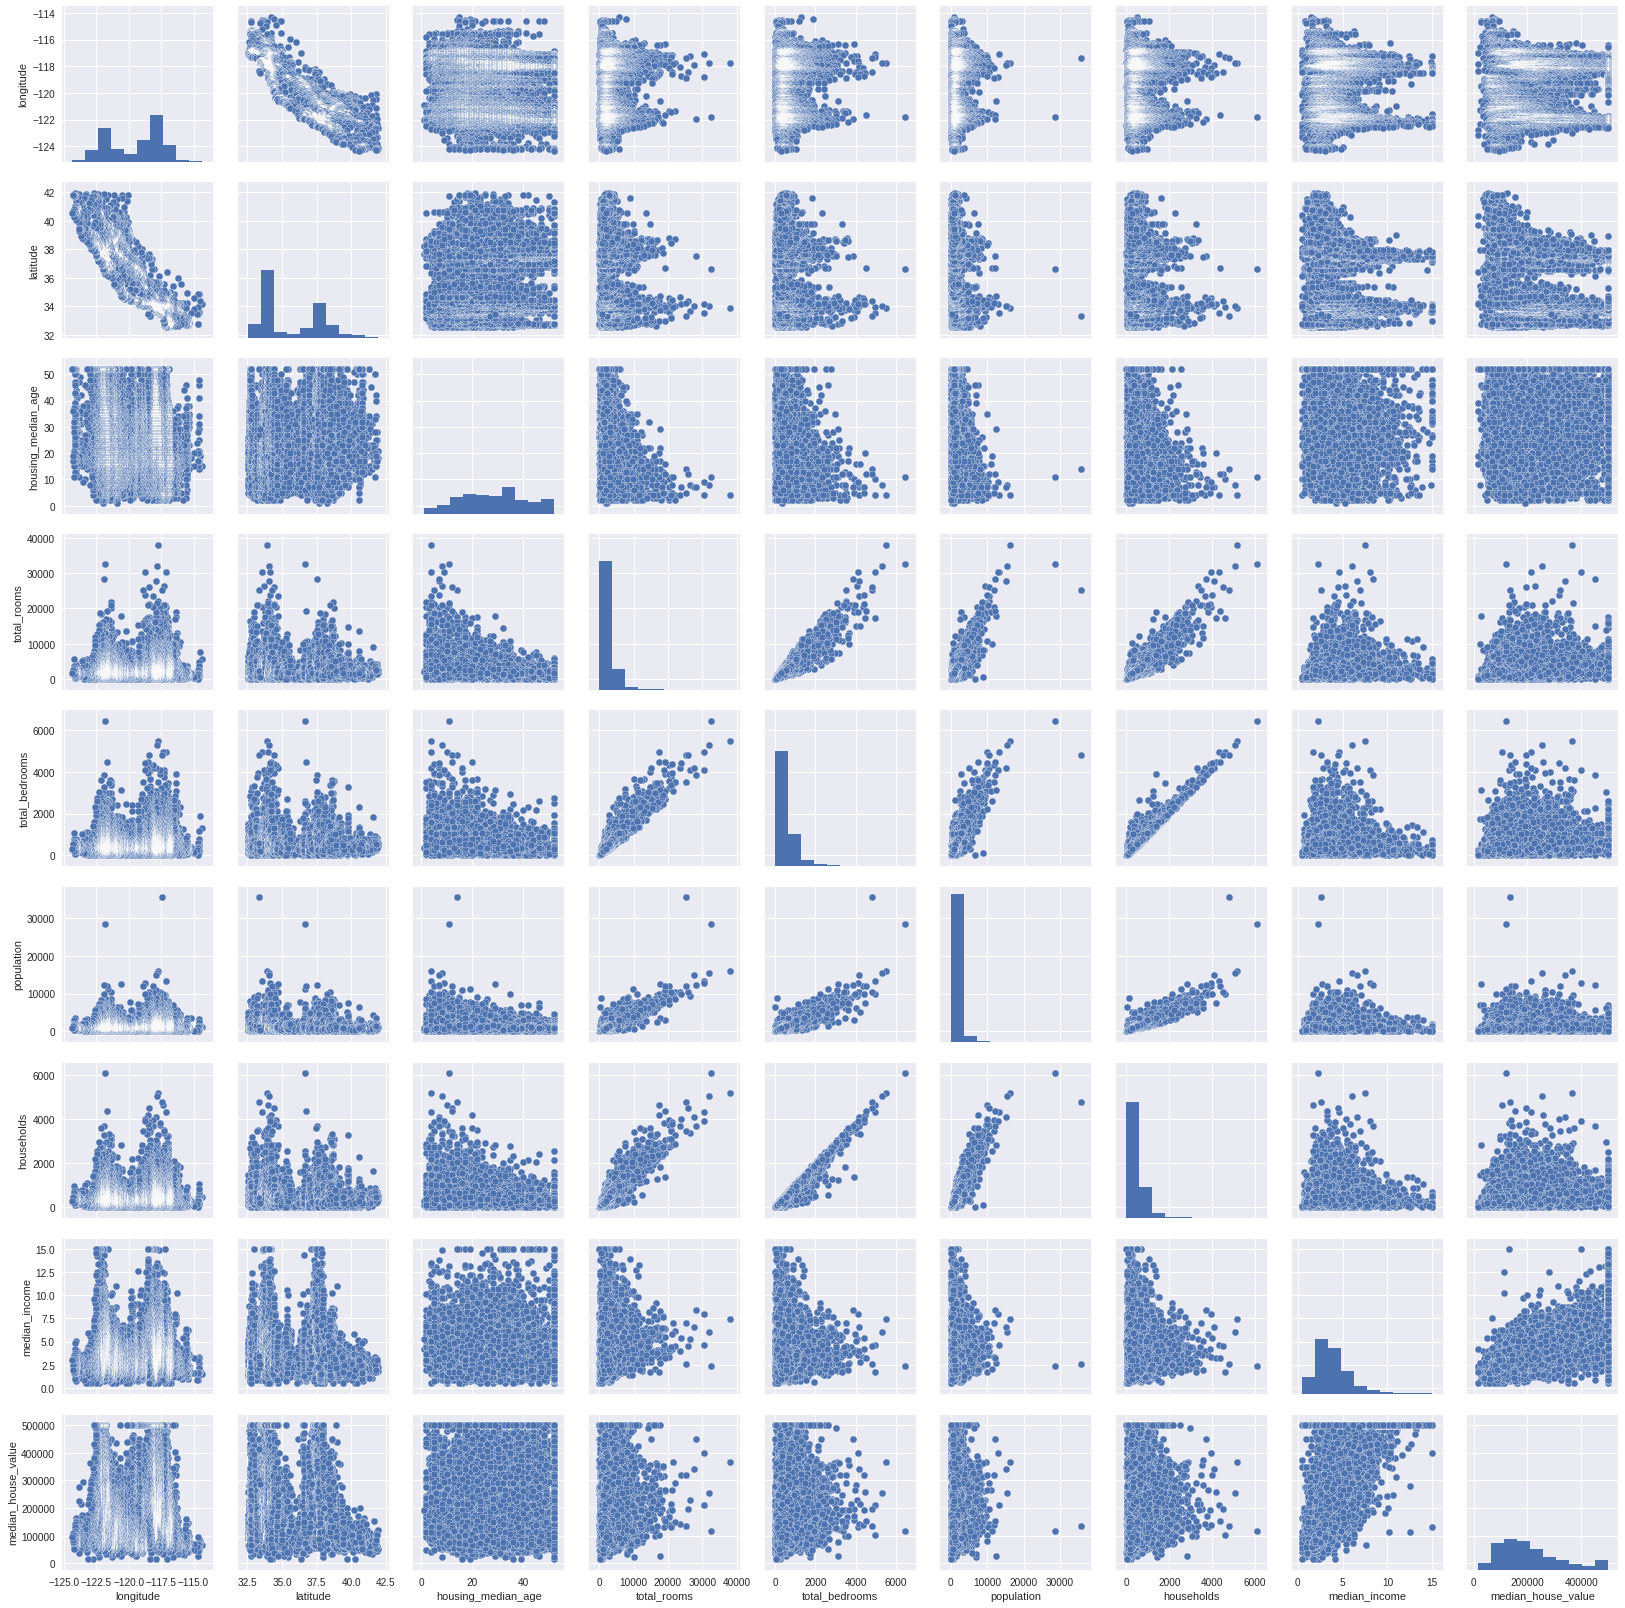

In [89]:
sns.pairplot(df)

seaborn も様々な種類のグラフが用意されているため、[公式ページ](https://seaborn.pydata.org/) や技術ブログで調べながら使ってみましょう。